# Session preview
Items that will be covered through the session:

- Geometric transform
- Histogram matching
- Histogram equalization


## Geometric transform

Mappings are two ways backward and forward :

🧭 1. Backward Mapping (Inverse Mapping)

For each pixel in the output image, we find where it came from in the input:

$$
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
=
T^{-1}
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
$$

✅ Advantage: Every pixel in the output is assigned a value.

❌ Disadvantage: Requires interpolation.

🚀 2. Forward Mapping

For each pixel in the input image, we compute where it goes in the output:

$$
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
=
T
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$


✅ Advantage: Conceptually simple and shows the geometric meaning directly.

❌ Disadvantage: Some output pixels may remain empty (holes), unless you post-process or interpolate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def apply_geometric_transform(image, kernel, output_shape=None): # backward
    start = time.time()

    if image.ndim == 2:  # grayscale
        h, w = image.shape
    else:
        h, w, _ = image.shape

    if output_shape is None:
        output_shape = (h, w)

    out_h, out_w = output_shape
    output = np.zeros((out_h, out_w, *image.shape[2:]), dtype=image.dtype)

    # Compute inverse transform (to map output -> input)
    inv_kernel = np.linalg.inv(kernel)

    # Generate coordinate grid for output image
    y_idx, x_idx = np.indices((out_h, out_w))
    ones = np.ones_like(x_idx)
    coords = np.stack([x_idx, y_idx, ones], axis=-1).reshape(-1, 3).T  # shape (3, N)

    # Map to input coordinates
    src_coords = inv_kernel @ coords
    src_coords /= src_coords[2, :]  # normalize homogeneous coordinates
    x_src = src_coords[0, :].reshape(out_h, out_w)
    y_src = src_coords[1, :].reshape(out_h, out_w)

    # Nearest neighbor sampling
    x_src = np.clip(np.round(x_src).astype(int), 0, w - 1)
    y_src = np.clip(np.round(y_src).astype(int), 0, h - 1)

    if image.ndim == 2:
        output = image[y_src, x_src]
    else:
        for c in range(image.shape[2]):
            output[..., c] = image[y_src, x_src, c]
    print(f"Time spent {time.time()-start}")
    return output

def apply_geometric_transform_forward(image, kernel, output_shape=None):
    start = time.time()
    if image.ndim == 2:
        h, w = image.shape
        channels = 1
    else:
        h, w, channels = image.shape

    if output_shape is None:
        output_shape = (h, w)
    out_h, out_w = output_shape

    output = np.zeros((out_h, out_w, channels), dtype=image.dtype)

    # Prepare input coordinates (float for safe math)
    y_idx, x_idx = np.indices((h, w))
    ones = np.ones_like(x_idx)
    coords = np.stack([x_idx, y_idx, ones], axis=-1).reshape(-1, 3).T
    coords = coords.astype(float)  # <--- Important: cast to float

    # Transform coordinates
    dst_coords = kernel @ coords
    dst_coords = dst_coords / dst_coords[2, :]  # normalize (safe now)

    # Round to nearest pixel
    x_dst = np.round(dst_coords[0, :]).astype(int)
    y_dst = np.round(dst_coords[1, :]).astype(int)

    # Filter valid coordinates (inside output boundaries)
    mask = (x_dst >= 0) & (x_dst < out_w) & (y_dst >= 0) & (y_dst < out_h)
    x_dst, y_dst = x_dst[mask], y_dst[mask]
    x_src, y_src = coords[0, mask].astype(int), coords[1, mask].astype(int)

    # Assign pixels (nearest neighbor)
    if channels == 1:
        output[y_dst, x_dst, 0] = image[y_src, x_src]
    else:
        for c in range(channels):
            output[y_dst, x_dst, c] = image[y_src, x_src, c]

    if channels == 1:
        output = output[..., 0]
    print(f"Time spent {time.time()-start}")
    return output


---

- Scaling

$$
T =
\begin{bmatrix}
c_x & 0 & 0 \\
0 & c_y & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

- Rotation
$$
T =
\begin{bmatrix}
cos(a) & sin(a) & 0 \\
-sin(a) & cos(a) & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

- Translation

$$
T =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
tx & ty & 1
\end{bmatrix}
$$ 
OR can be written as 

$$
T =
\begin{bmatrix}
1 & 0 & tx \\
0 & 1 & ty \\
0 & 0 & 1
\end{bmatrix}
$$ 

- Shear vertical

$$
T =
\begin{bmatrix}
1 & 0 & 0 \\
s_v & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

- Shear horizantal
$$
T =
\begin{bmatrix}
1 & s_h & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

In [2]:
def create_scale_kernel(x,y):
  return np.array([[x,0,0],
                   [0,y,0],
                   [0,0,1]])

def create_rotation_kernel(angle):
    theta = np.deg2rad(angle)

    return np.array([[np.cos(theta),np.sin(theta),0],
                    [-np.sin(theta),np.cos(theta),0],
                    [0,0,1]])

def create_translation_kernel(x,y):
  return np.array([[1,0,x],
                   [0,1,y],
                   [0,0,1]])

def create_SV_kernel(sv):
  return np.array([[1,0,0],
                   [sv,1,0],
                   [0,0,1]])

def create_SH_kernel(sh):
  return np.array([[1,sh,0],
                   [0,1,0],
                   [0,0,1]])

Image loaded successfully!
Scale kernel:
 [[ 0.98480775  0.17364818  0.        ]
 [-0.17364818  0.98480775  0.        ]
 [ 0.          0.          1.        ]]


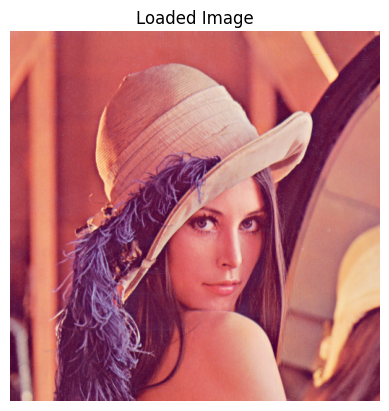

In [8]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/117.0 Safari/537.36"
}

url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
#response = requests.get(url, headers=headers)

#if response.status_code == 200:
try:
    image = Image.open("image.png").convert("RGB")
    image = np.array(image)

    #kernel = create_scale_kernel(0.5, 1)
    kernel = create_rotation_kernel(10)
    #kernel = create_translation_kernel(0.8,0.8)
    #kernel = create_SV_kernel(0.8)
    #kernel = create_SH_kernel(0.7)
    print("Image loaded successfully!")
    print("Scale kernel:\n", kernel)

    plt.imshow(image)
    plt.title("Loaded Image")
    plt.axis('off')
    plt.show()

except UnidentifiedImageError:
    print("Error: Could not identify the image file.")
# else:
#     print(f"Error: Failed to download the image. Status code: {response.status_code}")

Time spent 0.14037799835205078


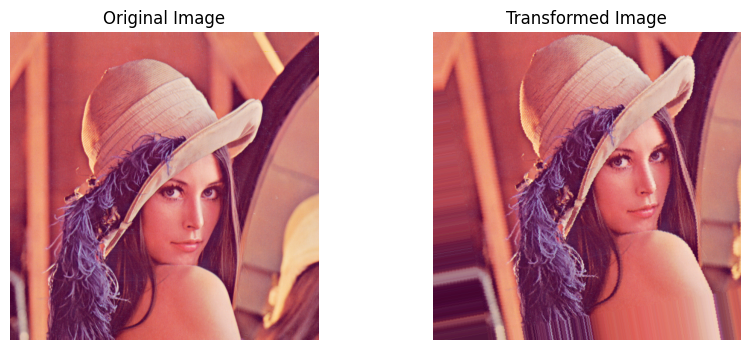

In [9]:
transformed_image = apply_geometric_transform(image, kernel)
# Display results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

Time spent 0.08647918701171875


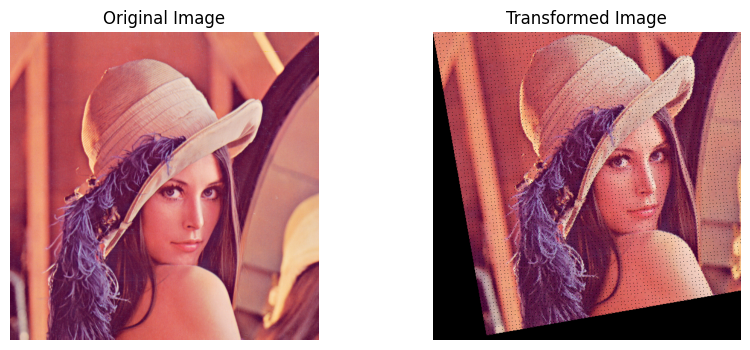

In [10]:
transformed_image = apply_geometric_transform_forward(image, kernel)
# Display results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

[[ 0.98480775  0.17364818  0.        ]
 [-0.17364818  0.98480775  0.        ]]


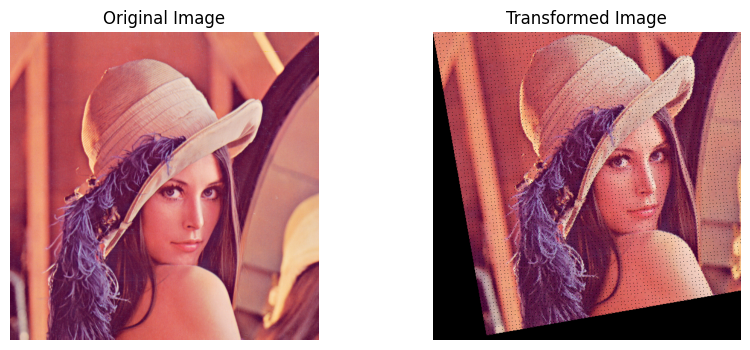

In [ ]:
import cv2
h, w = image.shape[:2]
affine_matrix = kernel[:2, :]
print(affine_matrix)
transformed = cv2.warpAffine(image, affine_matrix, (w, h))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

## Histogram operation
- Calculate a histogram
- Calculate a pdf and cdf
- Histogram equalization
- Histogram matching

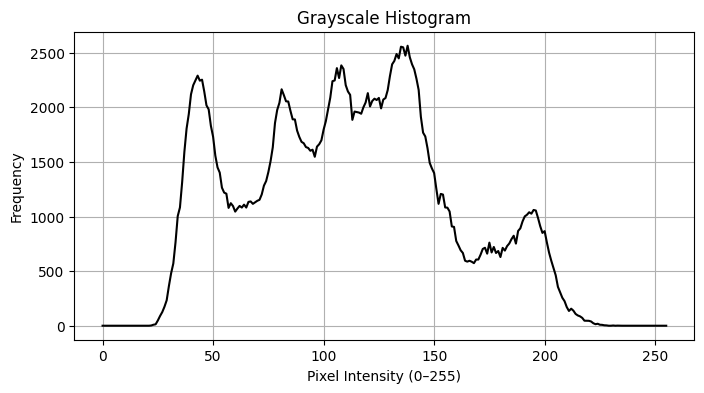

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Convert to grayscale (optional, if you just want one histogram)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Calculate histogram using OpenCV
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Plot using Matplotlib
plt.figure(figsize=(8,4))
plt.plot(hist, color='black')
plt.title('Grayscale Histogram')
plt.xlabel('Pixel Intensity (0–255)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

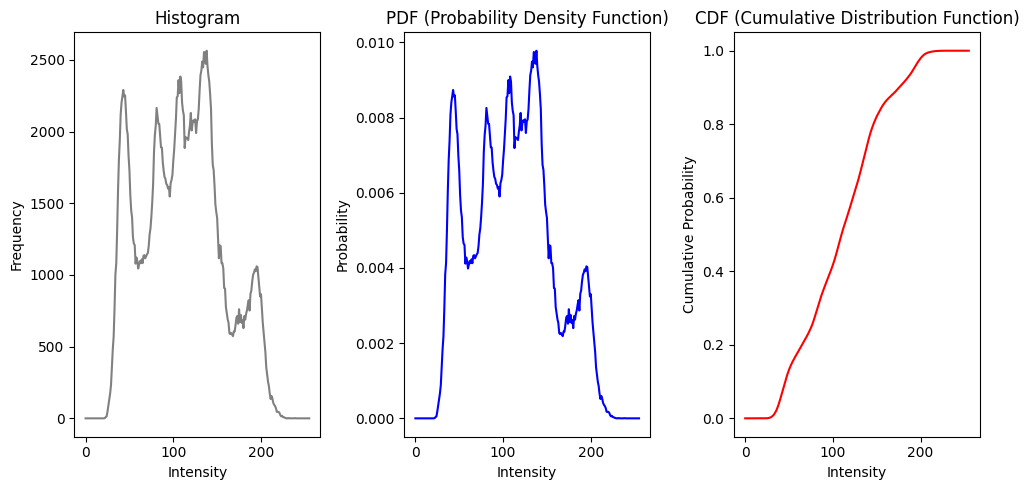

In [85]:
pdf = hist/hist.sum()
cdf = pdf.cumsum()
cdf_normalized = cdf/cdf.max()
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(hist, color='gray')
plt.title('Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.plot(pdf, color='blue')
plt.title('PDF (Probability Density Function)')
plt.xlabel('Intensity')
plt.ylabel('Probability')

plt.subplot(1,3,3)
plt.plot(cdf_normalized, color='red')
plt.title('CDF (Cumulative Distribution Function)')
plt.xlabel('Intensity')
plt.ylabel('Cumulative Probability')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Cumulative Probability')

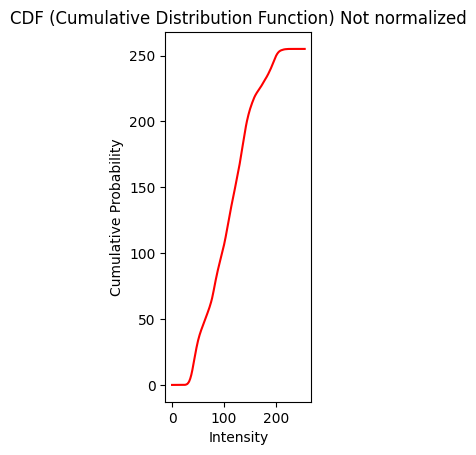

In [86]:
plt.subplot(1,3,3)
plt.plot(cdf * 255, color='red')
plt.title('CDF (Cumulative Distribution Function) Not normalized')
plt.xlabel('Intensity')
plt.ylabel('Cumulative Probability')

In [73]:
print(len(cdf))

256


Text(0.5, 1.0, 'Equalized Histogram')

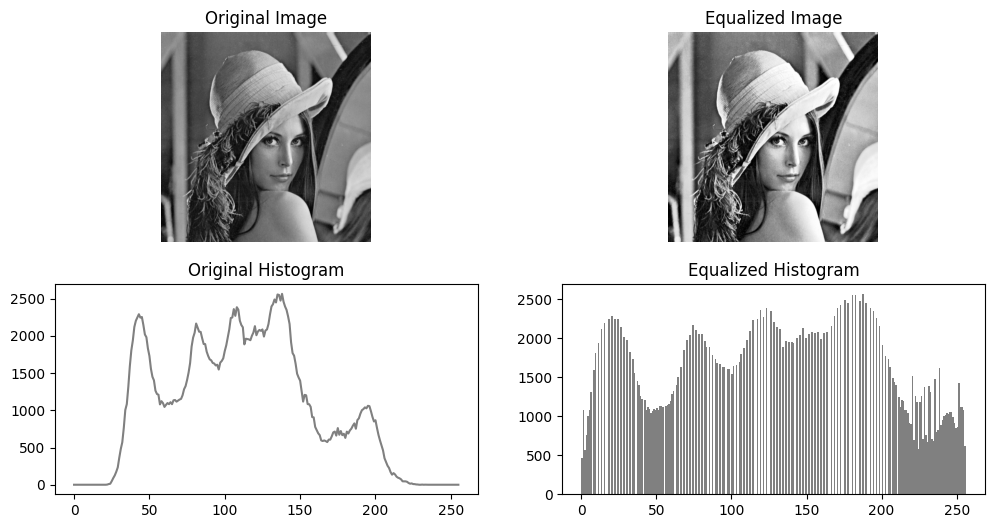

In [88]:
equalization_map = np.round(cdf  * 255).astype(np.uint8)
equalized = equalization_map[gray]
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(equalized, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

plt.subplot(2,2,3)
plt.plot(hist, color='gray')
plt.title('Original Histogram')

plt.subplot(2,2,4)
plt.hist(equalized.flatten(), bins=256, range=[0,256], color='gray')
plt.title('Equalized Histogram')

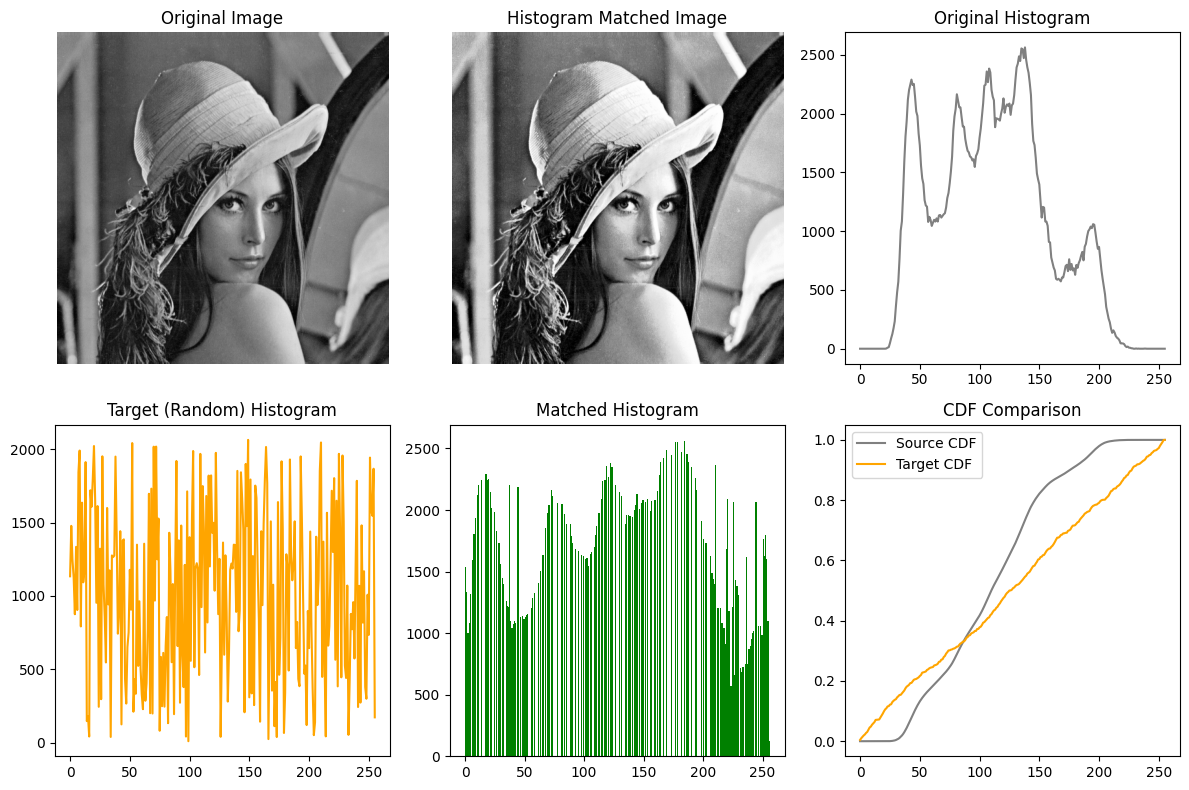

In [89]:
# 1. Compute source histogram and CDF
hist_src = cv2.calcHist([gray], [0], None, [256], [0,256]).flatten()
pdf_src = hist_src/hist_src.sum()
cdf_src = pdf_src.cumsum()
cdf_src /= cdf_src.max()

# 2. Create a random target histogram (sum=1)
np.random.seed(0)
hist_tgt = np.random.rand(256)
hist_tgt = hist_tgt / hist_tgt.sum()

# Compute target CDF
cdf_tgt = hist_tgt.cumsum()

# 3. Build mapping based on closest CDF values
mapping = np.zeros(256, dtype=np.uint8)
for i in range(256):
    # find the index in target CDF closest to the source CDF
    mapping[i] = np.argmin(np.abs(cdf_src[i] - cdf_tgt))

# 4. Apply mapping
matched = mapping[gray]

# 5. Plot results
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plt.imshow(gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(matched, cmap='gray')
plt.title('Histogram Matched Image')
plt.axis('off')

plt.subplot(2,3,3)
plt.plot(hist_src, color='gray')
plt.title('Original Histogram')

plt.subplot(2,3,4)
plt.plot(hist_tgt * gray.size, color='orange')
plt.title('Target (Random) Histogram')

plt.subplot(2,3,5)
plt.hist(matched.flatten(), bins=256, range=[0,256], color='green')
plt.title('Matched Histogram')

plt.subplot(2,3,6)
plt.plot(cdf_src, color='gray', label='Source CDF')
plt.plot(cdf_tgt, color='orange', label='Target CDF')
plt.legend()
plt.title('CDF Comparison')

plt.tight_layout()
plt.show()